In [1]:
import hpc05
client, dview, lview = hpc05.start_remote_and_connect(300, hostname='hpc05', profile='pbs_10GB',
    folder='~/work_sp2/Poisson_Solver')

Killed old intances of ipcluster.
Launching 300 engines in a ipcluster.
Waiting for 0 seconds for the log-file.
2021-01-08 22:17:53.712 [IPClusterStart] Attempting to load config file: ipcluster_config.py
2021-01-08 22:17:53.712 [IPClusterStart] Looking for ipcluster_config in /etc/ipython
2021-01-08 22:17:53.712 [IPClusterStart] Looking for ipcluster_config in /usr/local/etc/ipython
2021-01-08 22:17:53.712 [IPClusterStart] Looking for ipcluster_config in /home/cxliu/miniconda3/etc/ipython
2021-01-08 22:17:53.712 [IPClusterStart] Looking for ipcluster_config in /home/cxliu/.ipython/profile_pbs_10GB
2021-01-08 22:17:53.713 [IPClusterStart] Loaded config file: /home/cxliu/.ipython/profile_pbs_10GB/ipcluster_config.py
2021-01-08 22:17:53.713 [IPClusterStart] Looking for ipcluster_config in /home/cxliu
Found the log-file (/home/cxliu/.ipython/profile_pbs_10GB/log/ipcluster-20339.log) in 0 seconds.
2021-01-08 22:17:53.717 [IPClusterStart] Starting ipcluster with [daemon=True]
2021-01-08 22:

In [44]:
# import hpc05
# hpc05.kill_remote_ipcluster()

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../General')
import general_functions as gen

In [3]:
# %%px
import numpy as np
import kwant
import general_functions as gen

In [4]:
# %%px
sigma_0 = np.array([[1, 0], [0, 1]]) 
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

tau_0 = np.array([[1, 0], [0, 1]]) 
tau_x = np.array([[0, 1], [1, 0]])
tau_y = np.array([[0, -1j], [1j, 0]])
tau_z = np.array([[1, 0], [0, -1]])

In [5]:
import numpy as np
import kwant

# 0. Functions

In [6]:
#%%px
def make_bare_Al(a=1, thickness_Al=6, width=50):
    '''
    Parameters:
    -------------
    a: lattice constant in unit of nm
    thickness: thickness of Al in unit of nm
    width: width of Al in unit of nm
    
    Returns:
    ----------
    finalized kwant syst
    '''
    
    def shape(pos):
        x, y = pos
        in_x = -width / 2.0 <= x <= width / 2.0
        in_y = 0 <= y <= thickness_Al
        return in_x and in_y
    
    def onsite(site, t_Al, E_F, Ez, Delta, k):
        x, y = site.pos
        return (6 * t_Al - E_F - 2 * t_Al * np.cos(k)) * np.kron(tau_z, sigma_0) \
            + Ez * np.kron(tau_0, sigma_z) + Delta * np.kron(tau_x, sigma_0)
    
    def hopping(site1, site2, t_Al):
        return -t_Al * np.kron(tau_z, sigma_0)
    
    lat = kwant.lattice.square(a)
    syst = kwant.Builder()
    syst[lat.shape(shape, (0, 0))] = onsite
    syst[lat.neighbors()] = hopping
    return syst.finalized()

In [7]:
#%%px
def make_Al_EuS(a=1, thickness_Al=6, thickness_EuS=5, width=50):
    '''
    Parameters:
    -------------
    a: lattice constant in unit of nm, same for Al and EuS
    thickness_Al: thickness of Al in unit of nm
    thickness_EuS: thickness of EuS in unit of nm
    width: width of Al and EuS in unit of nm
    
    Returns:
    ----------
    finalized kwant syst
    '''
    
    def shape(pos):
        x, y = pos
        in_x = -width / 2.0 <= x <= width / 2.0
        in_y = -thickness_EuS <= y <= thickness_Al
        return in_x and in_y
    
    def onsite(site, t_Al, E_F, V_Al, Delta, t_EuS, E_gap, h_ex, t_tunnel, k, BdG):
        x, y = site.pos
        if BdG:
            pauli_matrix_kinetic = np.kron(tau_z, sigma_0)
            pauli_matrix_zeeman = np.kron(tau_0, sigma_z)
            pauli_matrix_sc = np.kron(tau_x, sigma_0)
        else:
            pauli_matrix_kinetic = sigma_0
            pauli_matrix_zeeman = sigma_z
            pauli_matrix_sc = 0.0 * sigma_0
        
        if y > a:
            return (6 * t_Al - E_F + V_Al(x, y) - 2 * t_Al * np.cos(k)) * pauli_matrix_kinetic \
                + Delta * pauli_matrix_sc
        elif y == a:
            return (5 * t_Al + t_tunnel - E_F + V_Al(x, y) - 2 * t_Al * np.cos(k)) * pauli_matrix_kinetic \
                + Delta * pauli_matrix_sc
        elif y == 0:
            return (5 * t_EuS + t_tunnel + E_gap - 2 * t_EuS * np.cos(k)) * pauli_matrix_kinetic \
                + h_ex * pauli_matrix_zeeman
        else:
            return (6 * t_EuS + E_gap - 2 * t_EuS * np.cos(k)) * pauli_matrix_kinetic \
                + h_ex * pauli_matrix_zeeman
        
    
    def hopping(site1, site2, t_Al, t_EuS, t_tunnel, BdG):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        
        if BdG:
            pauli_matrix_kinetic = np.kron(tau_z, sigma_0)
        else:
            pauli_matrix_kinetic = sigma_0
        
        if y1 >= a and y2 >= a:
            return -t_Al * pauli_matrix_kinetic
        elif (y1 == a and y2 == 0) or (y1 == 0 and y2 == a):
            return -t_tunnel * pauli_matrix_kinetic
        else:
            return -t_EuS * pauli_matrix_kinetic
        
    lat = kwant.lattice.square(a)
    syst = kwant.Builder()
    syst[lat.shape(shape, (0, 0))] = onsite
    syst[lat.neighbors()] = hopping
    return syst.finalized()

In [8]:
#%%px
def get_Gaussian_fun(E0):
    def Gaussian_fun(E):
        Gaussian_width = 5e-3
        return (np.sqrt(2*np.pi) * Gaussian_width)**-1 * np.exp(-(E - E0)**2 / (2 * Gaussian_width**2))
    return Gaussian_fun

In [9]:
#%%px
def get_V_Al(bare_Al_geo_params, U_disorder, thickness_disorder, seed=0):
    """
    We first define a kwant syst of bare Al, and then generate a disordered potential from it.
    Parameters:
    ------------
    bare_Al_geo_params: a dictionary for generating a kwant syst
    U_disorder: amplitude of the disorder potential in unit of eV
    thickness_disorder: width of the disordered region in unit of nm
    seed: the seed index for generating the disorder potential
    Returns:
    ----------
    V_Al: a disordered potential inside the superconducting region
    """
    
    def in_disorder_region(x, y):
        """
        A layer of several nm think within the outer surface of Al.
        """
        bool_in_disorder = (y >= bare_Al_geo_params['thickness_Al'] - thickness_disorder)
        return bool_in_disorder
    
    np.random.seed(seed=seed)
    syst = make_bare_Al(**bare_Al_geo_params) # a bare Al
    number_of_sites = len(syst.sites)
    positions = np.zeros((number_of_sites, 2))
    potential = np.zeros(number_of_sites)
    potential_total = (2 * np.random.rand(number_of_sites) - 1) * U_disorder
    for i, site in enumerate(syst.sites):
        positions[i, :] = site.pos
        if in_disorder_region(*site.pos):
            potential[i] = potential_total[i]
    V_Al = gen.get_V(positions, potential) # amplitude of potential will be amplified by 1e3.
    return V_Al

In [10]:
#%%px
def get_EuS_indices(syst):
    EuS_indices = []
    for i, site in enumerate(syst.sites):
        x, y = site.pos
        if y <= 0:
            EuS_indices.append(i)
    return np.asarray(EuS_indices)

In [11]:
#%%px
def weight_in_EuS(wf, norbs, EuS_indices):
    ldos = np.sum(np.reshape(np.abs(wf)**2, (-1, norbs)), axis=1)
    W = np.sum(ldos[EuS_indices])
    return W

# 1. Bare Al

In [ ]:
%%px
bare_Al_geo_params = dict(
    a=0.1,
    thickness=4,
    width=60
)
bare_Al = make_bare_Al(**bare_Al_geo_params)

In [73]:
%%px
bare_Al_ham_params = dict(
    t_Al=gen.t_function(m_eff=1, a=0.1),
    E_F=11.7e3,
    Ez=0.0,
    Delta=0.34,
    k=0.0
)

### A. Band diagram

In [71]:
%%px --local
def band_par_k(k):
    N = 50
    bare_Al_ham_params['k'] = k
    es = gen.eigen_problem(
        syst=bare_Al,
        ham_params=bare_Al_ham_params,
        sparse_matrix=True,
        k=N,
        return_wf=False
    )
    ks = k * np.ones(N)
    Eks = es
    return ks, Eks

In [10]:
k_range = np.linspace(2, 3.14, 400)
result = lview.map_async(band_par_k, k_range)
result.wait_interactive()
result = result.get()

 400/400 tasks finished after 1350 s
done


In [11]:
k_E = np.asarray(result)
ks = k_E[:, 0, :].flatten()
Eks = k_E[:, 1, :].flatten()

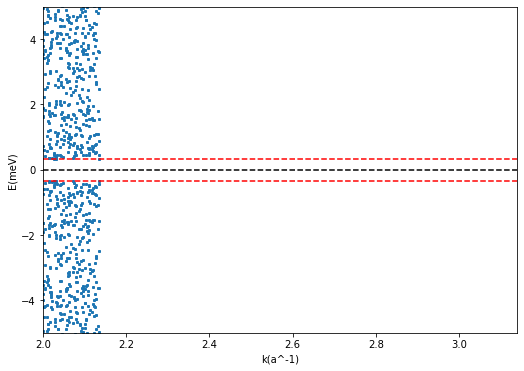

In [14]:
plt.figure(figsize=(8.5, 6))
plt.plot(k_range, 0.34 * np.ones(len(k_range)), c='red', ls='--')
plt.plot(k_range, -0.34 * np.ones(len(k_range)), c='red', ls='--')
plt.plot(k_range, 0.0 * np.ones(len(k_range)), c='k', ls='--')
plt.scatter(ks, Eks, s=4)
plt.xlim([min(k_range), max(k_range)])
plt.xlabel('k(a^-1)')
plt.ylim([-5, 5])
plt.ylabel('E(meV)')
plt.show()

### B. DOS

In [75]:
%%px --local
def dos_bare_par_k(k):
    E_range = np.linspace(-1, 1, 2001)
    dos_k = np.zeros(len(E_range))
    N = 50
    bare_Al_ham_params['k'] = k
    es = gen.eigen_problem(
        syst=bare_Al,
        ham_params=bare_Al_ham_params,
        sparse_matrix=True,
        k=N,
        return_wf=False
    )
    
    for E0 in es:
        Gaussian_fun = get_Gaussian_fun(E0=E0)
        dos_k += Gaussian_fun(E_range)
    return k, dos_k

In [76]:
k_range = np.linspace(0, 0.5, 2000)
result = lview.map_async(dos_par_k, k_range)
result.wait_interactive()
result = result.get()

2000/2000 tasks finished after  679 s
done


In [77]:
E_range = np.linspace(-1, 1, 2001)
dos_total = np.zeros(len(E_range))
for i in range(2000):
    dos_total += result[i][1]

In [69]:
#n = np.argmax(dos_total[1000:1350])
n = np.argmax(dos_total[1350:2000])
print(E_range[1350 + n])

0.4970000000000001


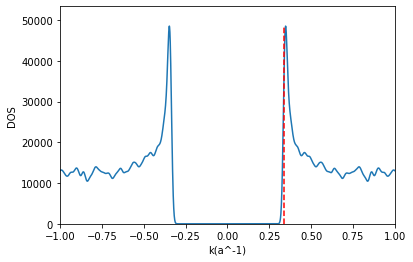

In [78]:
plt.figure()
plt.plot(E_range, dos_total)
plt.plot((0.34) * np.ones(100), np.linspace(0, max(dos_total), 100), 'r--')
#plt.plot((0.34 - 0.15) * np.ones(100), np.linspace(0, max(dos_total), 100), 'r--')
plt.xlabel('k(a^-1)')
plt.xlim([-1, 1])
plt.ylabel('DOS')
plt.ylim([0, max(dos_total) * 1.1])
plt.show()

# 2. Al-EuS hybrid model

In [12]:
#%%px
Al_EuS_geo_params = dict(
    a=0.1,
    thickness_Al=10,
    thickness_EuS=2,
    width=50
)
Al_EuS = make_Al_EuS(**Al_EuS_geo_params)
EuS_indices = get_EuS_indices(syst=Al_EuS)
positions = gen.get_positions(syst=Al_EuS)

In [13]:
#%%px
bare_Al_geo_params = dict(
    a=Al_EuS_geo_params['a'],
    thickness_Al=Al_EuS_geo_params['thickness_Al'],
    width=Al_EuS_geo_params['width']
)
bare_Al = make_bare_Al(**bare_Al_geo_params)
disorder_params = dict(
    bare_Al_geo_params=bare_Al_geo_params,
    U_disorder=0.0, ### in unit of eV
    thickness_disorder=2,
    seed=0
)
V_Al = get_V_Al(**disorder_params)

In [14]:
#%%px
Al_EuS_ham_params = dict(
    t_Al=gen.t_function(m_eff=1, a=Al_EuS_geo_params['a']),
    E_F=11.7e3,
    V_Al=V_Al,
    Delta=0.34,
    t_EuS=gen.t_function(m_eff=1, a=Al_EuS_geo_params['a']),
    E_gap=800,
    h_ex=50,
    t_tunnel=gen.t_function(m_eff=np.sqrt(1 * 1), a=Al_EuS_geo_params['a']),
    k=0.0,
    BdG=False
)

### 2A. Band and wavefunctions

In [15]:
N = 40
Al_EuS_ham_params['k'] = 0.0
es, wfs = gen.eigen_problem(
    syst=Al_EuS,
    ham_params=Al_EuS_ham_params,
    sparse_matrix=True,
    k=N,
    return_wf=True
)

In [27]:
i = 18
print(es[i], es[i+1] - es[i])

-1.4298144500813634 0.2632909644995931


In [28]:
1.8e-3 * 50 * 2

0.18

In [29]:
norbs = 2
ldos = np.sum(np.reshape(np.abs(wfs[:, i])**2, (-1, norbs)), axis=1)

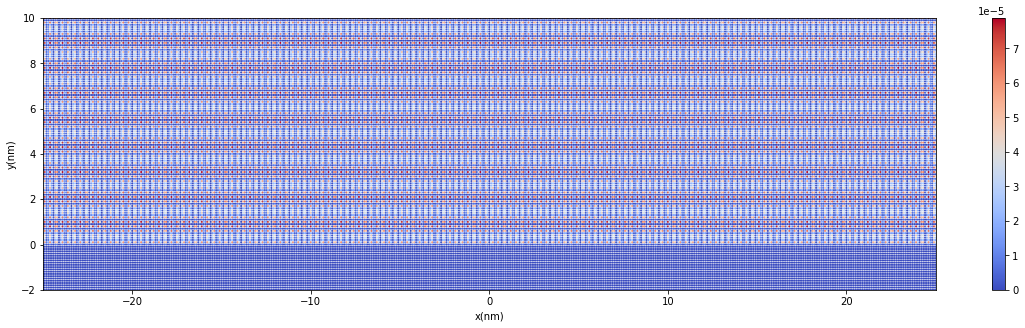

In [30]:
plt.figure(figsize=(20, 5))
plt.scatter(positions[:, 0], positions[:, 1], c=ldos, marker='o', s=1, cmap='coolwarm', vmin=0, vmax=max(ldos))
plt.xlabel('x(nm)')
plt.xlim([-25, 25])
plt.ylabel('y(nm)')
plt.ylim([-2, 10])
plt.colorbar()
plt.show()

In [29]:
%%px --local
def band_weight_hybrid_par_k(k):
    if Al_EuS_ham_params['BdG']:
        norbs = 4
    else:
        norbs = 2
    
    N = 40
    Al_EuS_ham_params['k'] = k
    es, wfs = gen.eigen_problem(
        syst=Al_EuS,
        ham_params=Al_EuS_ham_params,
        sparse_matrix=True,
        k=N,
        return_wf=True
    )
    
    ks = k * np.ones(N)
    Eks = es
    weights = np.zeros(N)
    for i in range(N):
        weights[i] = weight_in_EuS(wf=wfs[:, i], norbs=norbs, EuS_indices=EuS_indices)
    return ks, Eks, weights

In [36]:
k_range = np.linspace(0.0, 0.15, 1000)
result = lview.map_async(band_weight_hybrid_par_k, k_range)
result.wait_interactive()
result = result.get()

1000/1000 tasks finished after  411 s
done


In [37]:
k_E_W = np.asarray(result)
ks = k_E_W[:, 0, :].flatten()
Eks = k_E_W[:, 1, :].flatten()
Ws = k_E_W[:, 2, :].flatten()

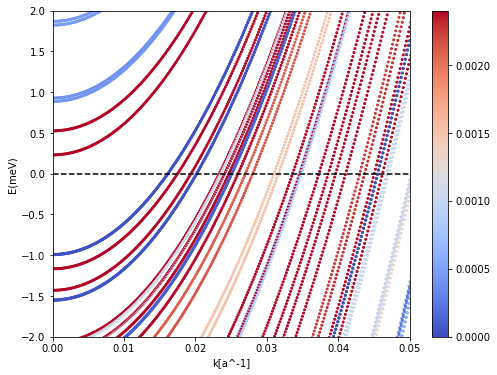

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(ks, Eks, c=Ws, marker='o', s=4, cmap='coolwarm', vmin=0, vmax=2.4e-3)
plt.plot(k_range, np.zeros(len(k_range)), c='black', ls='--')
plt.xlabel('k[a^-1]')
plt.xlim([0, 0.05])
plt.ylabel(r'E(meV)')
plt.ylim([-2, 2])
plt.colorbar()
plt.show()

In [41]:
max(Ws)

0.004426506354467305

In [42]:
np.mean(Ws)

0.0018133517875614186

In [43]:
min(Ws)

1.1779070900399627e-06

### 2B. DOS

In [20]:
%%px --local
def dos_hybrid_par_k(k):
    E_range = np.linspace(-1, 1, 2001)
    dos_k = np.zeros(len(E_range))
    N = 40
    Al_EuS_ham_params['k'] = k
    es = gen.eigen_problem(
        syst=Al_EuS,
        ham_params=Al_EuS_ham_params,
        sparse_matrix=True,
        k=N,
        return_wf=False
    )
    
    for E0 in es:
        Gaussian_fun = get_Gaussian_fun(E0=E0)
        dos_k += Gaussian_fun(E_range)
    return k, dos_k

In [21]:
k_range = np.linspace(0, 0.5, 3000)
result = lview.map_async(dos_hybrid_par_k, k_range)
result.wait_interactive()
result = result.get()

3000/3000 tasks finished after 1547 s
done


In [22]:
E_range = np.linspace(-1, 1, 2001)
dos_total = np.zeros(len(E_range))
for i in range(len(k_range)):
    dos_total += result[i][1]

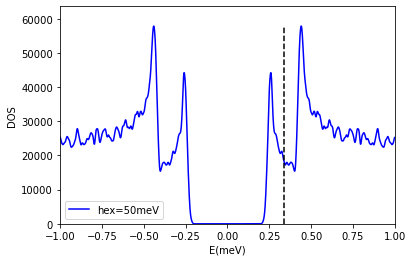

In [25]:
plt.figure()
plt.plot(E_range, dos_total, 'b', label='hex=50meV')
plt.plot((0.34) * np.ones(100), np.linspace(0, max(dos_total), 100), 'k--')
plt.xlabel('E(meV)')
plt.xlim([-1, 1])
plt.ylabel('DOS')
plt.ylim([0, max(dos_total) * 1.1])
plt.legend()
plt.show()

In [24]:
n1 = np.argmax(dos_total[1000:1340])
E_sd = np.round(E_range[1000 + n1], 4)

n2 = np.argmax(dos_total[1340:2000])
E_su = np.round(E_range[1340 + n2], 4)

splitting = np.round(E_su - E_sd, 4)
print(E_sd, E_su, splitting)

0.259 0.441 0.182


### C. Disorder potential in Al

In [71]:
bare_Al_geo_params = dict(
    a=0.1,
    thickness_Al=6,
    width=60
)
bare_Al = make_bare_Al(**bare_Al_geo_params)

In [72]:
disorder_params = dict(
    bare_Al_geo_params=bare_Al_geo_params,
    U_disorder=1,
    thickness_disorder=2,
    seed=0
)

In [73]:
V_Al = get_V_Al(**disorder_params)

In [74]:
positions_Al = gen.get_positions(bare_Al)
potential_Al = np.zeros(np.shape(positions_Al)[0])

for i, position in enumerate(positions_Al):
    potential_Al[i] = V_Al(*positions_Al[i, :])

In [75]:
np.shape(potential_Al)

(36661,)

In [77]:
min(potential_Al)

-999.9559035614456

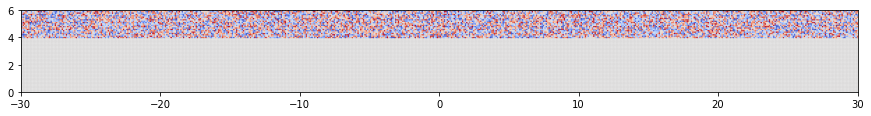

In [88]:
plt.figure(figsize=(15, 1.5))
plt.scatter(positions_Al[:, 0], positions_Al[:, 1], s=0.5, c=potential_Al, cmap='coolwarm', marker='o')
plt.xlim([-30, 30])
plt.ylim([0, 6])
plt.show()